# More profiling of dask vs xarray

### Author 
 - Julien Le Sommer, CNRS

### Context
 - April 2016, preparatory work for [oocgcm](https://github.com/lesommer/oocgcm)
 - following the analysis published [in this notebook](https://github.com/lesommer/notebooks/blob/master/Profiling_simple_derivative_computation_with_numpy_vs_dask_vs_xarray.ipynb) and discussed in this [thread](https://groups.google.com/forum/#!topic/xarray/TOX5BIc08WA)
 - more in depth analysis of xarray.DataArray.data versus dask arrays
 
### Purpose
 - compare the execution speed for computing derivatives with xarray.DataArray and dask arrays. 

### To do 
Following Stephan Hoyer's suggestions : 
 - [x] Focus on the second issue (dask.array function becoming 200x slower) first, because the data is -- or should be -- processed in a very similar way.
 - [x]  Simplify the logic as much as possible to identify the root cause. For example, try disabling post-processing in xarray by calling xr.open_dataset with decode_cf=False.
 - [x]  Understand if the slow down is in the graph construction or evaluation by timing them separately.
 - [x]  Look at chunks on the input and output arrays to make sure they are the same. Consider also doing the same on the dask graphs themselves. Visualize them by calling .data.visualize(), but keep in mind that this can be very slow if the task graph is large (you may need to subset the original data first).
 - [x] Use normal python profiling tools like %prun in the notebook, to see where most of the time is being spent.
 - [x]  Use dask's profiling tools to understanding what tasks are being called and how/if CPU/memory usage differs.



### Modules

In [1]:
#- import
import numpy as np
from netCDF4 import Dataset
import dask.array as da
import xarray as xr
from contextlib import contextmanager
import time

In [2]:
#- print versions
import dask 
print('dask version : ' + dask.__version__)
print('xarray version : ' + xr.__version__)

dask version : 0.8.1
xarray version : 0.7.1


### Define the arrays

#### Location of netcdf files

In [3]:
#- Medium size 2D dataset from NATL60 
#  array shape is (1,3454,5422)
file_2d_gridt = "/Users/lesommer/data/NATL60/NATL60-MJM155-S/1d/2008/NATL60-MJM155_y2008m01.1d_BUOYANCYFLX.nc"
varname_2d = "vosigma0"
file_2d_coord = "/Users/lesommer/data/NATL60/NATL60-I/NATL60_coordinates_v4.nc"

#### Size of the chunks 

In [4]:
chunks2d = (1727,2711)
xr_chunks2d = {'x': chunks2d[-1], 'y': chunks2d[-2]}

#### Functions for defining dask arrays

In [5]:
#- dask from netcdf :  dachk
def load_dachk(filename,varname,chunks,it=None):
    d = Dataset(filename).variables[varname]
    if it is None:
        array = da.from_array(d, chunks=chunks)
    else :
        array = da.from_array(d, chunks=(1,)+ chunks)[it]
    return array 

get_array2d_tgrid_dachk = lambda: load_dachk(file_2d_gridt,varname_2d,chunks2d,it=0)
get_array2d_e1u_dachk   = lambda: load_dachk(file_2d_coord,"e1u",chunks2d)

#### Functions for defining xarray.DataArray

In [6]:
#- xarray with chunks :  xachk
def load_xachk(filename,varname,xr_chunks,it=None,decode_cf=True):
    ds = xr.open_dataset(filename,chunks=xr_chunks,decode_cf=decode_cf)
    if it is None:
       array = ds.variables[varname]
    else:
        array = ds.variables[varname][it]
    return array.chunk(lock=True)

get_array2d_tgrid_xachk           = lambda: load_xachk(file_2d_gridt,varname_2d,xr_chunks2d,it=0)
get_array2d_e1u_xachk             = lambda: load_xachk(file_2d_coord,"e1u",xr_chunks2d)
get_array2d_tgrid_xachk_nodecode  = lambda: load_xachk(file_2d_gridt,varname_2d,xr_chunks2d,it=0,decode_cf=False)
get_array2d_e1u_xachk_nodecode    = lambda: load_xachk(file_2d_coord,"e1u",xr_chunks2d,decode_cf=False)

### Define the function that compute the x-derivative

In [7]:
#- Simple x-derivative function 
def derivative_da(array_tgrid,array_e1u,compute=True):
    di = lambda t: (np.roll(t,-1,axis=-1) - t) 
    depth = {-1: 1, -2: 0, -3:0}
    d = array_tgrid.map_overlap(di,depth=depth,boundary=0)
    if compute:
        return np.asarray(  (d / array_e1u ).compute() )
    else:
        return d / array_e1u

def derivative_xa(array_tgrid,array_e1u, compute=True):
    if compute:
        return np.asarray((array_tgrid.shift(x=-1) - array_tgrid) / array_e1u)
    else:
        return (array_tgrid.shift(x=-1) - array_tgrid) / array_e1u

def derivative_xa_as_da(array_tgrid,array_e1u,compute=True):
    return derivative_da(array_tgrid.data,array_e1u.data,compute=compute)

### Profiling tools

In [8]:
@contextmanager
def timeit_context(name):
    startTime = time.time()
    yield
    elapsedTime = time.time() - startTime
    print('{} takes {} ms'.format(name, int(elapsedTime * 1000))+'\n')

In [9]:
def derivative_profile_context(func_get_array_gridt,func_get_array_e1u,compute_func): 
    "Simple profiling function"
    with timeit_context('creating tgrid array'):
        array_tgrid = func_get_array_gridt()
    with timeit_context('creating e1u array'):
        array_e1u  = func_get_array_e1u()
    with timeit_context('computing x-derivative'):
        gx = compute_func(array_tgrid, array_e1u)
    print('output array is a ' + str(type(gx)))

### Reference experiments


In [10]:
# dask (netcdf with chunk) / dask (netcdf with chunk) 
derivative_profile_context(get_array2d_tgrid_dachk,get_array2d_e1u_dachk,derivative_da)

creating tgrid array takes 10 ms

creating e1u array takes 1 ms

computing x-derivative takes 1182 ms

output array is a <type 'numpy.ndarray'>


## Issue #1

In [11]:
# xarray (with chunk) / xarray (with chunk) 
derivative_profile_context(get_array2d_tgrid_xachk,get_array2d_e1u_xachk,derivative_xa)

creating tgrid array takes 18 ms

creating e1u array takes 13 ms

computing x-derivative takes 47003 ms

output array is a <type 'numpy.ndarray'>


Computating the derivarive is x65 longer with xarray (with xarray.DataArray.shift).

## Issue #2

In [12]:
# xarray (with chunk) / xarray (with chunk) (derivative as for dask array)
derivative_profile_context(get_array2d_tgrid_xachk,get_array2d_e1u_xachk,derivative_xa_as_da)

creating tgrid array takes 14 ms

creating e1u array takes 15 ms

computing x-derivative takes 150241 ms

output array is a <type 'numpy.ndarray'>


Computating the derivarive is x100 longer with xarray (with xarray.DataArray.data).

## Let's focus on issue #2
### 1. Impact of decode_cf

In [13]:
# xarray (with chunk) / xarray (with chunk) (derivative as for dask array)
derivative_profile_context(get_array2d_tgrid_xachk_nodecode,get_array2d_e1u_xachk_nodecode,derivative_xa_as_da)

creating tgrid array takes 21 ms

creating e1u array takes 18 ms

computing x-derivative takes 27206 ms

output array is a <type 'numpy.ndarray'>


**Observation #1** : postprocessing (decode_cf=True) affects notably the performances.

### 2. Timing separately the graph construction and the evaluation

In [14]:
# with pure dask
with timeit_context('creating tgrid array'):
    array_tgrid_da = get_array2d_tgrid_dachk()
with timeit_context('creating e1u array'):
    array_e1u_da  = get_array2d_e1u_dachk()
with timeit_context('graph construction for x-derivative'):
    _gx_da = derivative_da(array_tgrid_da, array_e1u_da,compute=False)
with timeit_context('actual evaluation of x-derivative'):
    gx_da = np.asarray(_gx_da.compute())

creating tgrid array takes 1 ms

creating e1u array takes 2 ms

graph construction for x-derivative takes 2 ms

actual evaluation of x-derivative takes 870 ms



In [15]:
# with xarray dask
with timeit_context('creating tgrid array'):
    array_tgrid_xa = get_array2d_tgrid_xachk_nodecode()
with timeit_context('creating e1u array'):
    array_e1u_xa  = get_array2d_e1u_xachk_nodecode()
with timeit_context('graph construction for x-derivative'):
    _gx_xa = derivative_xa_as_da(array_tgrid_xa, array_e1u_xa,compute=False)
with timeit_context('actual evaluation of x-derivative'):
    gx_xa = np.asarray(_gx_xa.compute())

creating tgrid array takes 13 ms

creating e1u array takes 13 ms

graph construction for x-derivative takes 2 ms

actual evaluation of x-derivative takes 12053 ms



**Observation #2** : The overhead is associated with the actual evaluation. Note also that creating the intermediate array _gx slows down the all process. 

### 3. Look at the chunks in input and output xarray.DataArray objects

In [16]:
print('first input chunks :  ' + str(array_tgrid_xa.chunks))
print('second input chunks : ' + str(array_e1u_xa.chunks))
print('output chunks :       ' + str(_gx_xa.chunks))

first input chunks :  ((1727, 1727), (2711, 2711))
second input chunks : ((1727, 1727), (2711, 2711))
output chunks :       ((1727, 1727), (2711, 2711))


### 4. Vizualizing the graphs

In [17]:
from dask.dot import dot_graph

In [18]:
# pure dask
dot_graph(_gx_da.dask)

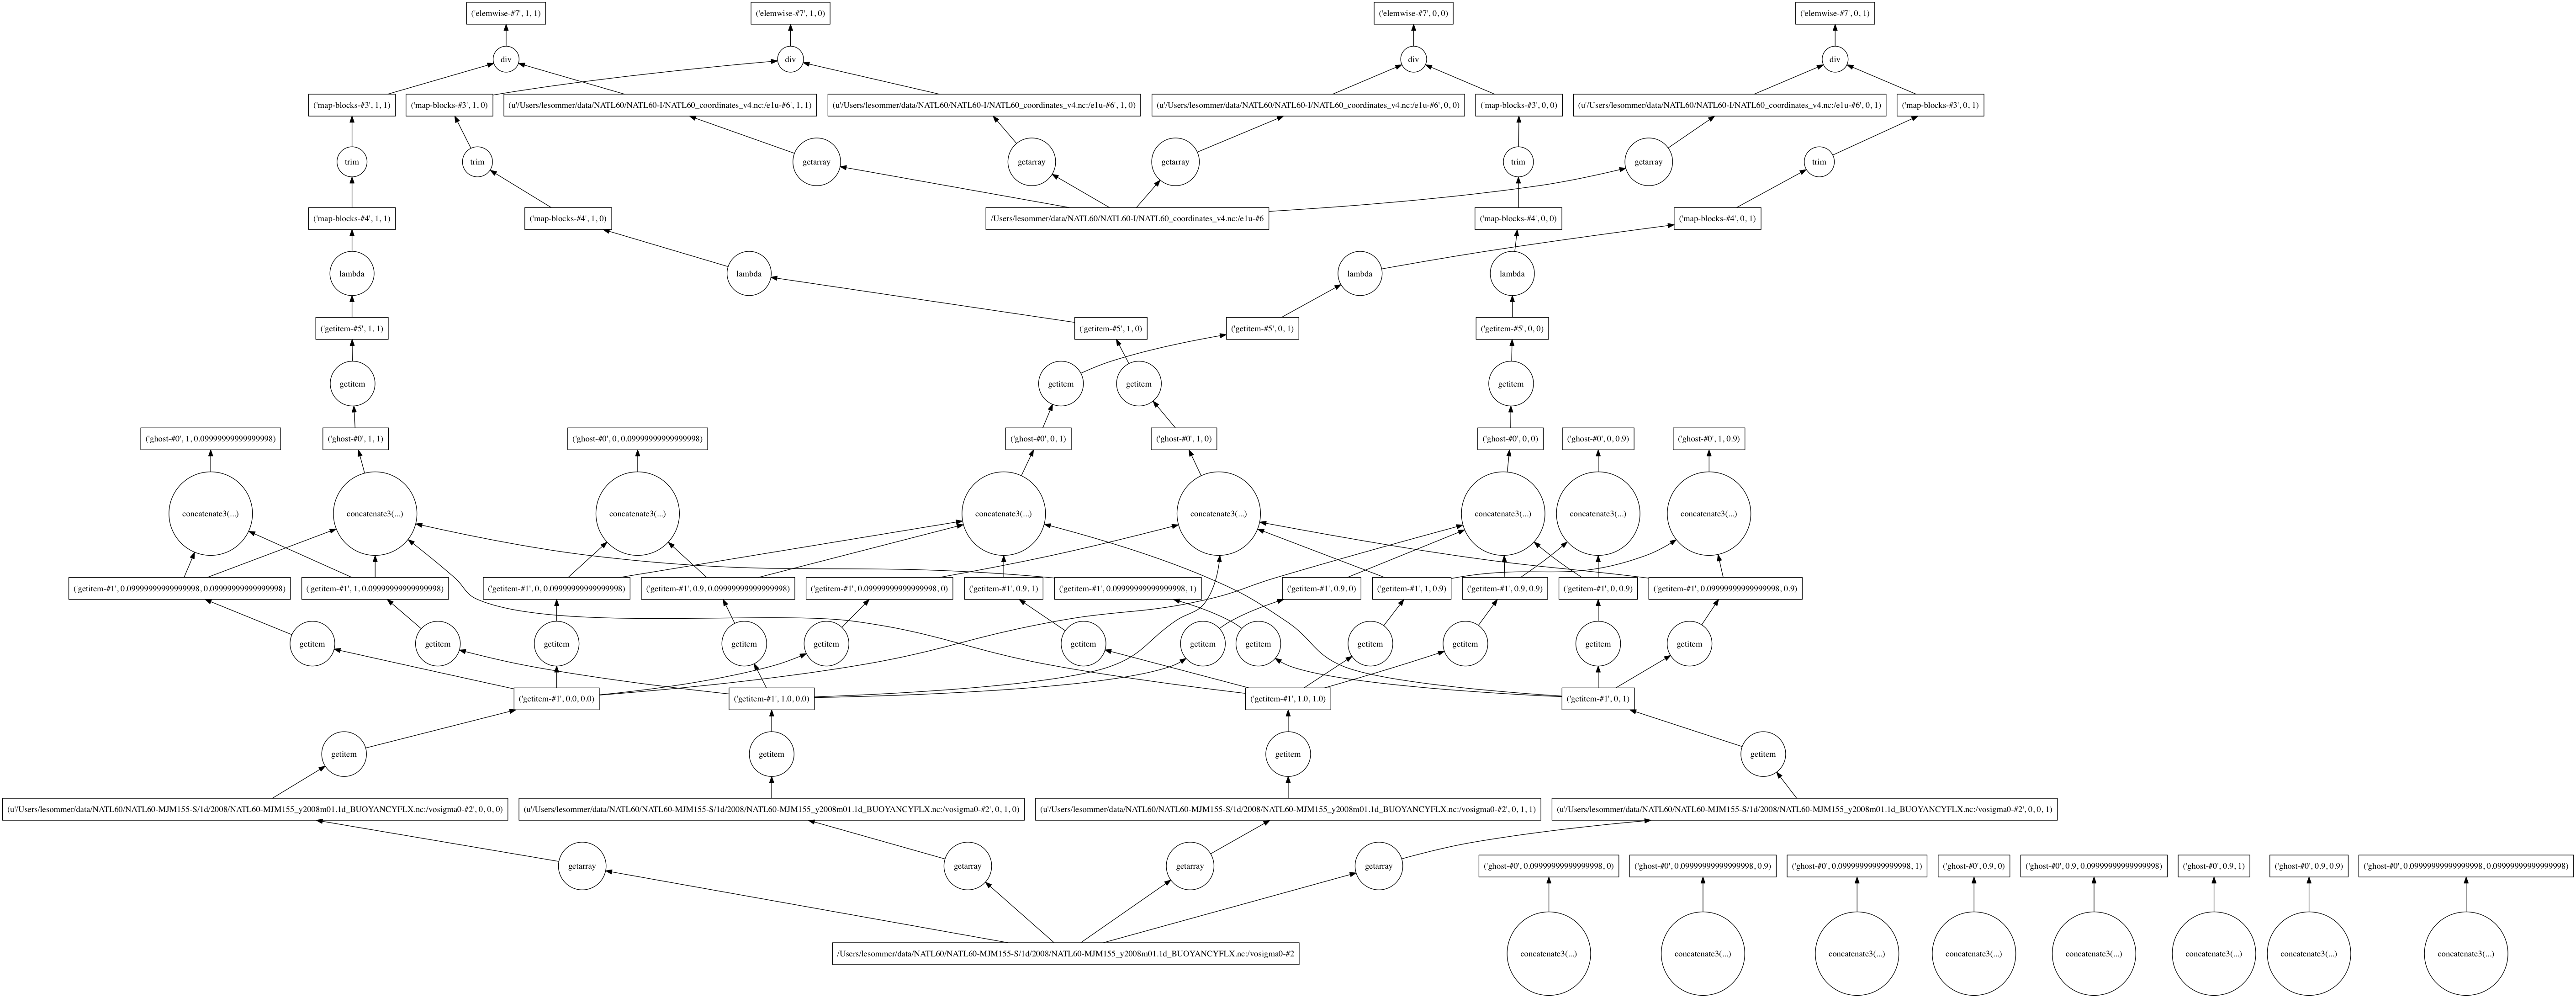

In [19]:
# xarray.DataArray.data 
dot_graph(_gx_xa.dask)

### 5. Profiling with %prun

In [20]:
prof_da = %prun -r out_da = _gx_da.compute()
prof_da.print_stats()

          21378 function calls (20700 primitive calls) in 1.103 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       57    0.997    0.017    0.997    0.017 {method 'acquire' of 'thread.lock' objects}
        1    0.073    0.073    0.073    0.073 core.py:2920(concatenate3)
        1    0.017    0.017    1.103    1.103 base.py:36(compute)
      347    0.003    0.000    0.007    0.000 core.py:182(get_dependencies)
     3682    0.002    0.000    0.002    0.000 core.py:27(istask)
      840    0.002    0.000    0.003    0.000 core.py:147(_deps)
     3725    0.001    0.000    0.001    0.000 {isinstance}
      130    0.001    0.000    0.002    0.000 rewrite.py:375(_match)
   209/48    0.000    0.000    0.001    0.000 core.py:284(subs)
     1567    0.000    0.000    0.000    0.000 {method 'pop' of 'list' objects}
   268/28    0.000    0.000    0.001    0.000 optimize.py:211(functions_of)
     1516    0.000    0.000    0.000    0.0

<pstats.Stats instance at 0x109314128>

In [21]:
prof_xa = %prun -r out_xa = _gx_xa.compute()
prof_xa.print_stats()

          24297 function calls (23561 primitive calls) in 13.501 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       65   13.396    0.206   13.396    0.206 {method 'acquire' of 'thread.lock' objects}
        1    0.073    0.073    0.073    0.073 core.py:2920(concatenate3)
        1    0.015    0.015   13.501   13.501 base.py:36(compute)
      347    0.003    0.000    0.008    0.000 core.py:182(get_dependencies)
     4360    0.002    0.000    0.002    0.000 core.py:27(istask)
     1060    0.002    0.000    0.003    0.000 core.py:147(_deps)
     4355    0.001    0.000    0.001    0.000 {isinstance}
      134    0.001    0.000    0.002    0.000 rewrite.py:375(_match)
   231/48    0.000    0.000    0.001    0.000 core.py:284(subs)
     1863    0.000    0.000    0.000    0.000 {method 'pop' of 'list' objects}
   296/28    0.000    0.000    0.001    0.000 optimize.py:211(functions_of)
     3185    0.000    0.000    0.000    0.

<pstats.Stats instance at 0x10393fc20>

### 6.  Profiling with dask profiling tools
with http://dask.pydata.org/en/latest/diagnostics.html

In [22]:
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
from cachey import nbytes
from dask.diagnostics import visualize

In [23]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [24]:
with Profiler() as prof, CacheProfiler(metric=nbytes) as cprof:
    out_da = _gx_da.compute()
    visualize([prof,cprof])

In [25]:
with Profiler() as prof, CacheProfiler(metric=nbytes) as cprof:
    out_xa = _gx_xa.compute()
    visualize([prof, cprof])